In [2]:
import numpy as np
import sympy
import qsymm
from qsymm.kwant_integration import builder_to_model, bloch_to_builder, \
                                    kp_to_builder
import kwant
from collections import OrderedDict
import matplotlib.pyplot as plt

sympy.init_printing(print_builtin=True)
np.set_printoptions(precision=2, suppress=True, linewidth=150)

# Graphene

Using Kwant, we construct the Hamiltonian for bulk graphene.

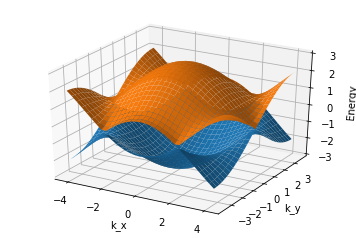

In [3]:
lat = kwant.lattice.honeycomb(norbs=[1, 1])
sym = kwant.TranslationalSymmetry(lat.vec((1, 0)), lat.vec((0, 1)))

bulk = kwant.Builder(sym)
bulk[[lat.a(0, 0), lat.b(0, 0)]] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()
kwant.wraparound.plot_2d_bands(wrapped);

To perform symmetry analysis on the Hamiltonian, we convert the unfinalized bulk model to the format that qsymm uses.

In [4]:
ham = builder_to_model(bulk)

To verify that the Hamiltonian looks as expected, qsymm allows for easy conversion to sympy.

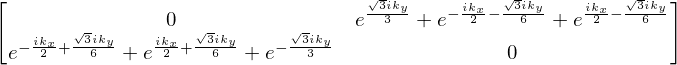

In [5]:
ham.tosympy(nsimplify=True)

The symmetry group is the full 2D hexagonal group combined with time-reversal and particle-hole symmetry.

In [6]:
hex_group_2D = qsymm.groups.hexagonal()

In [7]:
sg, cg = qsymm.symmetries(ham, hex_group_2D, prettify=True)
print(len(sg))
print(set(sg) == qsymm.groups.hexagonal())
print(cg)

48
True
[]


For instance, the Hamiltonian has the chiral symmetry $C = -\sigma_z$, and time-reversal symmetry $T = I \mathcal{K}$.

In [8]:
C = [symmetry for symmetry in sg if symmetry.conjugate is False and
     symmetry.antisymmetry is True and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), np.eye(2))]

In [9]:
print(len(C))
print(C[0].U)

1
[[0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j]]


In [10]:
T = [symmetry for symmetry in sg if symmetry.conjugate is True and
     symmetry.antisymmetry is False and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), np.eye(2))]

In [11]:
print(len(T))
print(T[0].U)

1
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


Adding an onsite term $\propto \sigma_z$ breaks the chiral symmetry.

In [12]:
staggered_onsite = qsymm.BlochModel({qsymm.sympify('U'): np.array([[1, 0], [0, -1]])}, momenta=ham.momenta)

In [13]:
ham_with_onsite = ham + staggered_onsite

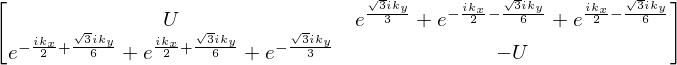

In [14]:
ham_with_onsite.tosympy(nsimplify=True)

Consequently, we no longer find a chiral symmetry of the Hamiltonian.

In [15]:
sg, cg = qsymm.symmetries(ham_with_onsite, hex_group_2D, prettify=True)
print(len(sg))
print(cg)

24
[]


In [16]:
C = [symmetry for symmetry in sg if symmetry.conjugate is False and
     symmetry.antisymmetry is True and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), np.eye(2))]

In [17]:
len(C) == 0

True

Finally, we convert the qsymm Hamiltonian back to Kwant. For this, we need to specify the number of sites (atoms) per unit cells along with their number of orbitals. In addition, we must provide the positions of the sites within a single unit cell, and the lattice vectors.

In [18]:
norbs = OrderedDict({'A': 1, 'B': 1})  # A and B atom per unit cell, one orbital each.
# We extract the lattice vectors and the atom positions from the Kwant model above.
lat_vecs = [lat.vec((1, 0)), lat.vec((0, 1))]  # Bravais lattice vectors.
atom_coords = [site.pos for site in bulk.sites()]  # Atom coordinates

In [19]:
bulk_from_model = bloch_to_builder(ham_with_onsite, norbs, lat_vecs, atom_coords)

With the onsite potential $U = 0$, we reproduce the graphene dispersion above.

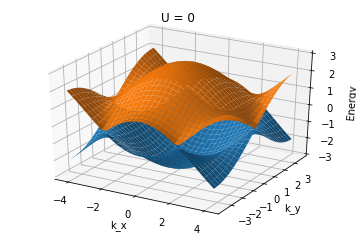

In [20]:
params = dict(U=0)
wrapped = kwant.wraparound.wraparound(bulk_from_model).finalized()
kwant.wraparound.plot_2d_bands(wrapped, params=params);

# Quantum spin Hall effect

We look at the symmetries of the BHZ model for the quantum spin Hall effect, and then use it to construct a Kwant system using the discretizer.

In [21]:
hamiltonian = """
       + C * identity(4) + M * kron(sigma_0, sigma_z)
       - B * (k_x**2 + k_y**2) * kron(sigma_0, sigma_z)
       - D * (k_x**2 + k_y**2) * kron(sigma_0, sigma_0)
       + A * k_x * kron(sigma_z, sigma_x)
       - A * k_y * kron(sigma_0, sigma_y)
       """

In [22]:
ham = qsymm.Model(hamiltonian=hamiltonian, momenta=[0, 1])

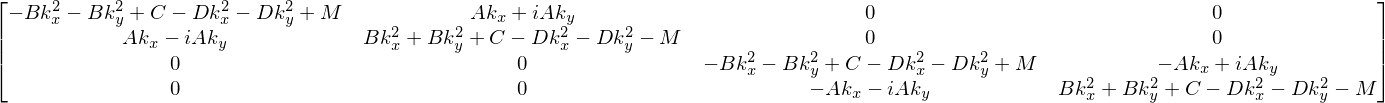

In [23]:
ham.tosympy(nsimplify=True)

We search for time-reversal, inversion and particle-hole symmetries. The Hamiltonian has time-reversal and inversion symmetry, but not particle-hole.

In [24]:
candidates = [qsymm.PointGroupElement(np.eye(2), True, False, None),
              qsymm.PointGroupElement(-np.eye(2), False, False, None),
              qsymm.PointGroupElement(np.eye(2), True, True, None)]

In [25]:
sg, cs = qsymm.symmetries(ham, candidates=candidates, continuous_rotations=True, prettify=True)

/home/tinkerer/qsymm/qsymm/symmetry_finder.py:711: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  R = np.sum((1j * R * v[i] for i, R in enumerate(Rs())), axis=0)
/home/tinkerer/qsymm/qsymm/symmetry_finder.py:719: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  l = np.sum((l * v[blockind + j] for j, l in enumerate(Ls)), axis=0)


In [26]:
T = [symmetry for symmetry in sg if symmetry.conjugate is True and
     symmetry.antisymmetry is False and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), np.eye(2))]
I = [symmetry for symmetry in sg if symmetry.conjugate is False and
     symmetry.antisymmetry is False and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), -np.eye(2))]
P = [symmetry for symmetry in sg if symmetry.conjugate is True and
     symmetry.antisymmetry is True and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), np.eye(2))]

In [27]:
print(len(T), len(I), len(P))

1 1 0


The Hamiltonian also has a continuous onsite spin symmetry, and a continuous rotation symmetry.

In [28]:
cs

[ContinuousGroupGenerator(
 None,
 [[-0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
  [ 0. +0.j -0.5+0.j  0. +0.j  0. +0.j]
  [ 0. +0.j  0. +0.j  0.5+0.j  0. +0.j]
  [ 0. +0.j  0. +0.j  0. +0.j  0.5+0.j]],
 ), ContinuousGroupGenerator(
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]],
 [[-0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
  [ 0. +0.j  0.5+0.j  0. +0.j  0. +0.j]
  [ 0. +0.j  0. +0.j  0.5+0.j  0. +0.j]
  [ 0. +0.j  0. +0.j  0. +0.j -0.5+0.j]],
 )]

We can obtain a Kwant system from this qsymm Hamiltonian. Because this is not a lattice but a continuum Hamiltonian, we use the Kwant discretizer, which discretizes the Hamiltonian to form a tight binding model.

Doing so, we reproduce the dispersion of the nanoribbon present in the [Kwant discretization tutorial](https://kwant-project.org/doc/1/tutorial/discretize).

In [29]:
a = 20
kwant_BHZ = kwant.continuum.discretize(ham.tosympy(nsimplify=True), grid=a)

In [30]:
L = 2000
W = 1000

def shape(site):
    (x, y) = site.pos
    return (0 <= y < W and 0 <= x < L)

def lead_shape(site):
    (x, y) = site.pos
    return (0 <= y < W)

syst = kwant.Builder()
syst.fill(kwant_BHZ, shape, (0, 0))

lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead.fill(kwant_BHZ, lead_shape, (0, 0))

syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

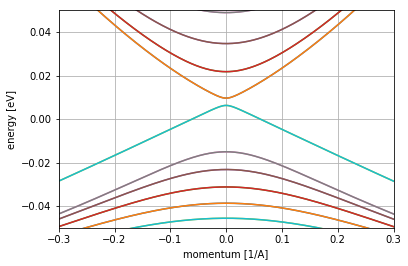

In [31]:
params = dict(A=3.65, B=-68.6, D=-51.1, M=-0.01, C=0)
kwant.plotter.bands(syst.leads[0], params=params,
                    momenta=np.linspace(-0.3, 0.3, 201), show=False)

plt.grid()
plt.xlim(-.3, 0.3)
plt.ylim(-0.05, 0.05)
plt.xlabel('momentum [1/A]')
plt.ylabel('energy [eV]')
plt.show()

Of course, we can map the discretized Kwant model back to  qsymm, and analyze its symmetries once more.

In [32]:
discretized_model = builder_to_model(kwant_BHZ)

In [33]:
sg, cs = qsymm.symmetries(discretized_model, candidates=candidates, continuous_rotations=True, prettify=True)

As before, we find the time-reversal and inversion symmetries, but no particle-hole.
Of course, the discretized model does not have continuous rotation symmetry, so we only find the continuous onsite symmetry from before.

In [34]:
T = [symmetry for symmetry in sg if symmetry.conjugate is True and
     symmetry.antisymmetry is False and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), np.eye(2))]
I = [symmetry for symmetry in sg if symmetry.conjugate is False and
     symmetry.antisymmetry is False and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), -np.eye(2))]
P = [symmetry for symmetry in sg if symmetry.conjugate is True and
     symmetry.antisymmetry is True and
     qsymm.linalg.allclose(np.array(symmetry.R).astype(float), np.eye(2))]

In [35]:
print(len(T), len(I), len(P))

1 1 0


In [36]:
cs

[ContinuousGroupGenerator(
 None,
 [[ 0.5+0.j  0. +0.j  0. +0.j  0. +0.j]
  [ 0. +0.j  0.5+0.j  0. +0.j  0. +0.j]
  [ 0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
  [ 0. +0.j  0. +0.j  0. +0.j -0.5+0.j]],
 )]

The discretized model does however have fourfold rotation symmetry, which we find using qsymm.

In [37]:
R = np.array([[0, -1],
              [1, 0]])
rotation = [qsymm.PointGroupElement(R, False, False, None)]

In [38]:
sg, cs = qsymm.symmetries(discretized_model, candidates=rotation, prettify=True)

In [39]:
rot4 = [symmetry for symmetry in sg if symmetry.conjugate is False and
        symmetry.antisymmetry is False and
        np.allclose(symmetry.R, R)]
print(len(rot4))

1


# 6-orbital model of bulk SnTe

Model that includes spinful p-orbitals on both sublattices, 12 bands in total. Includes onsite SOC and $pp\sigma$ hoppings

In [ ]:
def SnTe_6orb():
    """Make bulk 6-band model of SnTe from https://arxiv.org/pdf/1202.1003.pdf

    second_neighbor: bool (default True)
        Whether to include second neighbor hopping.
    """
    sigmas = qsymm.groups.spin_matrices(1/2)
    L = qsymm.groups.L_matrices(d=3, l=1)
    L_dot_S = np.sum([np.kron(sigmas[i], L[i]) for i in range(3)], axis=0)

    def onsite(site, m1, m2, lam1, lam2):
        m = np.array([m1, m2])
        lam = np.array([lam1, lam2])
        # choose onsite terms based on which sublattice
        a = np.sum(site.tag) % 2
        os = m[a] * np.eye(6)
        # L dot S onsite SoC
        spinorb = lam[a] * L_dot_S
        # x, y, z = site.pos
        os = os + spinorb
        return os

    def hopping(site1, site2, t11, t12, t22):
        t = np.array([[t11, t12], [t12, t22]])
        # which sublattice
        a = np.sum(site1.tag) % 2
        b = np.sum(site2.tag) % 2
        d = site1.tag - site2.tag
        # ppsigma bonding
        dtd = np.kron(np.eye(2), np.outer(d, d)/np.dot(d, d))
        # Use the appropriate hopping depending on sublattices
        hop = t[a, b] * dtd
        return hop

    # Cubic rocksalt structure with FCC symmetry
    lat = kwant.lattice.general(np.eye(3), norbs=6)
    # Default translation vectors of FCC structure
    translations = kwant.lattice.TranslationalSymmetry([1, 1, 0], [1, 0, 1], [0, 1, 1])
    syst = kwant.Builder(symmetry=translations)

    # Populate the builder using the cubic lattice sites
    # Two sublattices
    syst[lat(0, 0, 0)] = onsite
    syst[lat(0, 0, 1)] = onsite

    # First and second neighbor hoppings
    syst[lat.neighbors(1)] = hopping
    syst[lat.neighbors(2)] = hopping

    return syst

In [ ]:
syst = SnTe_6orb()
SnTe_model = builder_to_model(syst)

Find symmetry group, it is full cubic $\times$ TR

In [ ]:
sg, cs = qsymm.symmetries(SnTe_model, candidates=qsymm.groups.cubic(), prettify=True)
print(len(sg), len(cs))

Check the symmetry without second neighbor hoppings

In [ ]:
SnTe_model2 = builder_to_model(syst).subs(dict(t11=0, t22=0))

We find an extra unphysical spin conservation

In [ ]:
sg2, cs2 = qsymm.symmetries(SnTe_model2, candidates=qsymm.groups.cubic(), prettify=True)
print(len(sg2), len(cs2))

Inspect the new conserved quantities

In [ ]:
cs2

# Wire with chiral symmetry

Kwant is used to generate the tight-binding model for a finite cross section wire

In [ ]:
import wire.funcs as funcs

Define symmetry candidates, in 1D the only nontrivial space-group element is inversion, besides add both TR and PH.

The $\mathbf{k\cdot p}$ Hamiltonian is discretized with a lattice constant of $a = 10$ nm. The wire and shell diameter of $r_1 = 15$ nm, $r_2 = 30$ nm used here allow the calculation in about 30 seconds, the example shown in the paper uses $r_1 = 25$ nm, $r_2 = 40$ nm and takes about 10 minutes.

The electric field is in the $z$ direction all along.

In [ ]:
candidates = {qsymm.PointGroupElement(np.eye(1), True, False, None),
              qsymm.PointGroupElement(np.eye(1), False, True, None),
              qsymm.PointGroupElement(-np.eye(1), False, False, None)
             }
candidates = qsymm.groups.generate_group(candidates)
len(candidates)

r1=15
r2=30
Vz = lambda *pos: pos[2]
color = lambda site: ('w' if (np.dot(site.pos, site.pos)) < r1**2 else 'r')

Make system with mirror symmetry and magnetic field in $x$ direction.

In [ ]:
syst_pars = dict(a=10, angle=0, coverage_angle=100, r1=r1, r2=r2, shape='circle',
                 A_correction=True, with_shell=True, rotate_spin_orbit=False)

lead = funcs.make_lead(**syst_pars)

kwant.plot(lead, site_color = color);

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The system has the full 8-element symmetry group.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add magnetic field in $z$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0.1, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The symmetry group still contains an effective time-reversal symmetry $M_y T$

In [ ]:
%time symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add magnetic field in $y$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0.1, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

The symmetry group only contains $C_{2z} T$, which doesn't prevent band-tilting.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Move shell such that it breaks $M_y$

In [ ]:
syst_pars = dict(a=10, angle=45, coverage_angle=100, r1=r1, r2=r2, shape='circle',
                 A_correction=True, with_shell=True, rotate_spin_orbit=False)

lead = funcs.make_lead(**syst_pars)

kwant.plot(lead, site_color = color);

Field only along the wire.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

Mirror symmetry $M_x$ is preserved.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]

Add field in $z$ direction.

In [ ]:
params = dict(alpha=20, B_x=0.5, B_y=0, B_z=0.1, Delta=110, g=50,
              orbital=True, mu_sc=100, mu_lead=10, c_tunnel=3/4,
              V=Vz,  **funcs.constants.__dict__)

model = builder_to_model(lead, params=params)

All symmetry is broken except for particle-hole.

In [ ]:
symset, cg = qsymm.symmetries(model, candidates, sparse_linalg=True)
print(len(symset), len(cg))
[(s.R, s.conjugate, s.antisymmetry) for s in symset]